In [143]:
import numpy as np
import seaborn as sns; sns.set()
sns.set(color_codes=True)
sns.set(font_scale=1.2)
import sys
sys.path.append(r"../src")
from visulizer import *
from feature_importance_helper import *
from feature_interaction_score_utilities import *
from FIS_explainer import fis_explainer
from Utilities import *
#plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Conventional workflow

### Load data from csv file

In [3]:
X_df = load_data(filename='../data/data_withLattice.csv')
X_features = X_df.iloc[:,1:-5]
feature_names = X_features.columns.values

y_multilabel = X_df.iloc[:,-5:]
label_names = y_multilabel.columns.values

print('Feature names: \n', feature_names)
print('Label names: ', label_names)

Feature names: 
 ['Sc' 'Ti' 'V' 'Cr' 'Zr' 'Nb' 'Mo' 'Hf' 'Ta' 'C' 'N' 'F' 'H' 'O' 'OH'
 'NULL' 'Li' 'Na' 'K' 'Mg']
Label names:  ['Voltage(V)' 'Theoretical_capacity (mAh/g)' 'Induced_Z_charge(mAh/g)'
 'In-plane lattice' 'In-plane lattice(intercalated)']


## MXen descriptor

In [226]:
data_index = []
for index, row in X_features.iterrows():
    indices = [i for i, x in enumerate(row) if x == 1]
    indices[1] = indices[1]-9
    indices[2] = indices[2]-11
    indices[3] = indices[3]-16
    data_index.append(indices)
X_features_classes = np.array(data_index)

array([[0, 0, 4, 0],
       [0, 1, 4, 0],
       [0, 0, 1, 0],
       ...,
       [7, 1, 0, 3],
       [8, 0, 0, 3],
       [8, 1, 0, 3]])

In [6]:
X = X_features.to_numpy()
y = y_multilabel.to_numpy()
scaler = preprocessing.MinMaxScaler()
y = scaler.fit_transform(y)

In [15]:
from torch.utils.data import Dataset, TensorDataset
import torch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [16]:
from train import Net
model = Net()
model.load_state_dict(torch.load('../results/model/best_model_ANN.pth'))
model.eval()

Net(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [80]:
print('The loss of trained NN on the test set is {}, training process is illustrated below'.format(mean_squared_error(y_test, model(X_test_tensor).detach().numpy())))
train_loss = np.load('../results/model/train_loss.npy')
test_loss = np.load('../results/model/test_loss.npy')

The loss of trained NN on the test set is 0.00289397889419277, training process is illustrated below


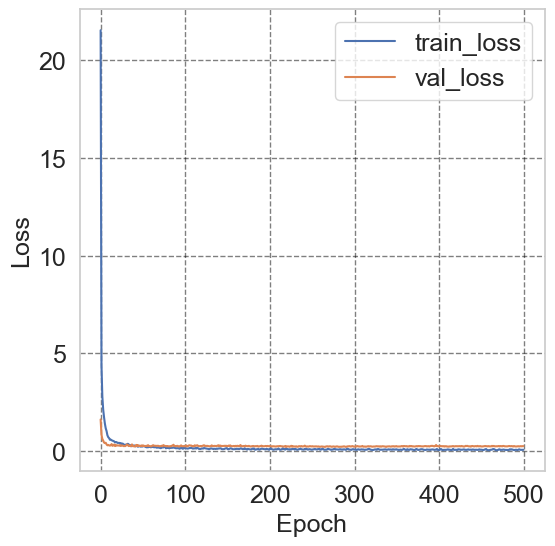

In [89]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.plot(train_loss[:], label='train_loss')
ax.plot(test_loss[:], label='val_loss')
ax.set_axisbelow(True)
ax.xaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.yaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_facecolor("white")
ax.legend(bbox_to_anchor=(1.0, 1.0), shadow=False, facecolor='white', fontsize=18)
ax.set_xlabel('Epoch',fontsize=18)
ax.set_ylabel('Loss',fontsize=18)
plt.savefig('../results/figs/training_process.png', bbox_inches='tight')
plt.show()

### PCA with NN and RF

### NN results

In [90]:
from sklearn.manifold import TSNE
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
# tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = pca.fit_transform(y_test)
z_pred = pca.fit_transform((model(X_test_tensor).detach().numpy()))

### RF results

In [ ]:
model_RFR = RandomForestRegressor(random_state=42, max_features=None,n_jobs=-1,
                                 criterion='squared_error',min_impurity_decrease=1e-07,max_depth=13,
                                 min_samples_leaf=1,min_samples_split=2, n_estimators=170)
model_RFR.fit(X_train, y_train)
z = pca.fit_transform(y_test)
z_pred = pca.fit_transform((model_RFR.predict(X_test)))
# plt.scatter(z[:,0], z[:,1], color='blue')
# plt.scatter(z_pred[:,0], z_pred[:,1], color='red')

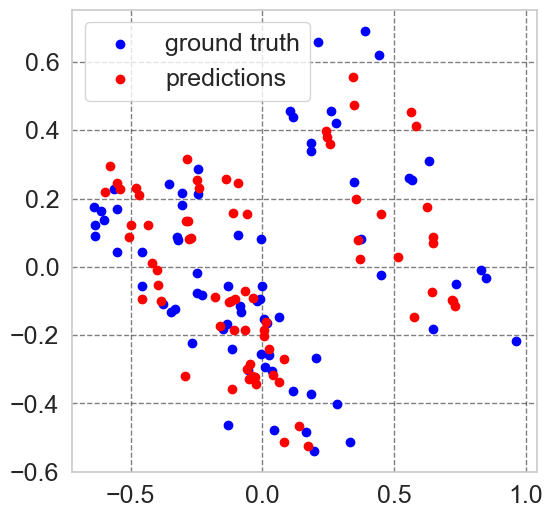

In [114]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.scatter(z[:,0], z[:,1], color='blue', label='ground truth')
ax.scatter(z_pred[:,0], z_pred[:,1], color='red', label='predictions')
# ax.set_axisbelow(True)
ax.xaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.yaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
# ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_facecolor("white")
ax.legend(loc=2, shadow=False, facecolor='white', fontsize=18)
# ax.set_xlabel('PCA',fontsize=18)
plt.savefig('../results/figs/pred_vs_gth_rf.png', bbox_inches='tight')
plt.show()



## Search best parameters

In [51]:
model_RFR = RandomForestRegressor(random_state=42, max_features=None,n_jobs=-1,
                                 criterion='squared_error',min_impurity_decrease=1e-07,max_depth=13,
                                 min_samples_leaf=1,min_samples_split=2, n_estimators=170)
model_RFR.fit(X_train, y_train)

cv_scores = cross_val_score(model_RFR, X_train, y_train, cv=10)
accuracy = np.mean(cv_scores)
uncertainty = np.std(cv_scores)*2
training_score = model_RFR.score(X_train, y_train)
testing_score = model_RFR.score(X_test, y_test)

print('Training score:', np.round(training_score, 6))
#print('CV Scores:', np.round(cv_scores, 6))
print('CV Accuracy:',np.round(accuracy, 6),'+/-',np.round(uncertainty, 6))
print('Testing score:', np.round(testing_score, 6))

mse = mean_squared_error(y_test, model_RFR.predict(X_test))
rmse = mean_squared_error(y_test, model_RFR.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, model_RFR.predict(X_test))
print('RMSE:', np.round(rmse, 6))
print('MAE:', np.round(mae, 6))
print('MSE:', np.round(mse, 6))

Training score: 0.97356
CV Accuracy: 0.812677 +/- 0.086036
Testing score: 0.839653
RMSE: 0.073924
MAE: 0.052127
MSE: 0.00697


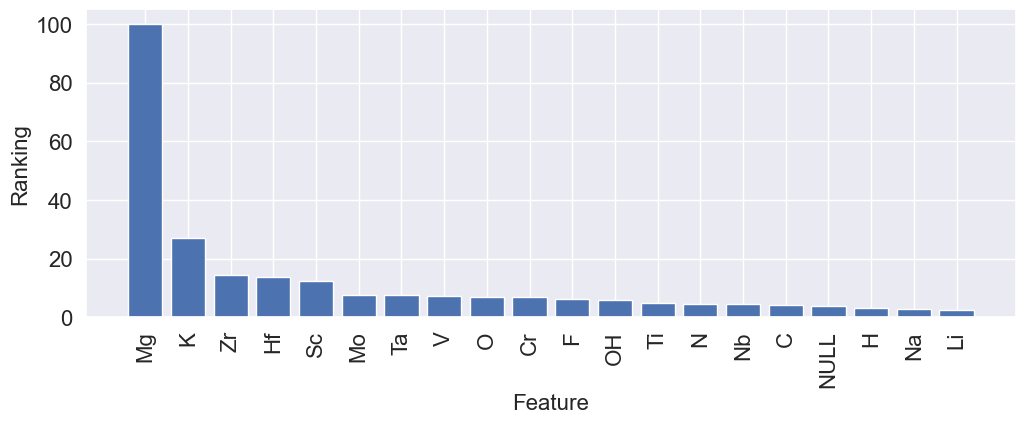

In [52]:
X_features.columns =(list(X_features.columns.values) )
plot_feature_importance(
    X_features.columns,
    model_RFR.feature_importances_,
    show_cols = 20
)
# plt.tight_layout()
# plt.subplots_adjust(bottom=0.2)
# plt.savefig(f'Figure/multi_Importance_RFR.png', dpi = 300, bbox_inches='tight')
plt.show()

In [53]:
# RFECV
rfecv = RFECV(model_RFR, step=1, cv=10, scoring='neg_mean_absolute_error')
rfecv.fit(X_train, y_train)

RFECV(cv=10,
      estimator=RandomForestRegressor(max_depth=13, max_features=None,
                                      min_impurity_decrease=1e-07,
                                      n_estimators=170, n_jobs=-1,
                                      random_state=42),
      scoring='neg_mean_absolute_error')

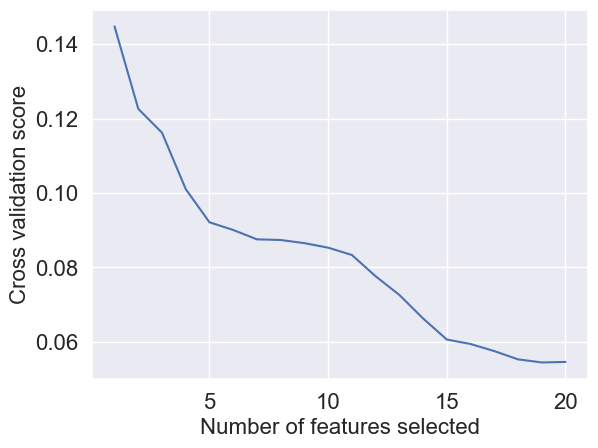

Optimal number of features : 19


In [54]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected", fontsize=16)
plt.ylabel("Cross validation score", fontsize=16)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
scores = -rfecv.cv_results_["mean_test_score"]
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), scores)
# plt.savefig(f'Figure/multi_Optimal_RFR.png', dpi = 300, bbox_inches='tight')
plt.show()
print("Optimal number of features : %d" % rfecv.n_features_)

## Apply new framework

In [58]:
import os
ROOT_DIR = os.getcwd()
OUTPUT_DIR = ROOT_DIR+'/../results'

In [247]:
fis_explainer_mlp = fis_explainer(model, X_test, y_test, epsilon_rate=0.1, loss_fn='regression', wrapper_for_torch=True)

In [248]:
content_in_results=os.listdir(OUTPUT_DIR)
analysis_results = {'FIS-in-Rashomon-set':{'saved':False, 'path':'', 'variable_name':'FIS_in_Rashomon_set'},
                    'FIS-joint-effect-raw':{'saved':False, 'path':'', 'variable_name':'rset_joint_effect_raw'},
                    'FIS-main-effect-raw':{'saved':False, 'path':'', 'variable_name':'rset_main_effect_raw'},'FIS-main-effect-processed':{'saved':False, 'path':'', 'variable_name':'rset_main_effect_processed'},'Ref-in-Rashomon-set-analysis':{'saved':False, 'path':'', 'variable_name':'ref_analysis'}}
if len(content_in_results) == 0:
    print('Nothing in the directory {}'.format(OUTPUT_DIR))
else:
    for result in analysis_results:
        for content in content_in_results:
            if result in content:
                analysis_results[result]['saved'] = True
                result_path = OUTPUT_DIR+'/'+content
                analysis_results[result]['path'] = result_path
                att_name = analysis_results[result]['variable_name']
                setattr(fis_explainer_mlp, att_name, load_json(result_path))
                break
        if not analysis_results[result]['saved']:
            print('{} is not in {}'.format(result, content_in_results))

In [249]:
fis_explainer_mlp.ref_explain()

In [250]:
fis_explainer_mlp.rset_explain()

2023-06-28 14:56:01,966 INFO FIS_explainer rset_explain Start exploring the possible models
2023-06-28 14:56:01,967 INFO FIS_explainer rset_explain Already exists, skip
2023-06-28 14:56:01,968 INFO FIS_explainer rset_explain Calculating all main effects of features range(0, 20) for all models in the Rashomon set
2023-06-28 14:56:01,968 INFO FIS_explainer rset_explain Already exists, skip
2023-06-28 14:56:01,969 INFO FIS_explainer rset_explain Already exists, skip
2023-06-28 14:56:01,971 INFO feature_interaction_score_utilities get_fis_in_r Calculating :pair 0 with index 0 and 1
2023-06-28 14:56:01,972 INFO feature_interaction_score_utilities get_fis_in_r Calculating :pair 1 with index 0 and 2
2023-06-28 14:56:01,973 INFO feature_interaction_score_utilities get_fis_in_r Calculating :pair 2 with index 0 and 3
2023-06-28 14:56:01,973 INFO feature_interaction_score_utilities get_fis_in_r Calculating :pair 3 with index 0 and 4
2023-06-28 14:56:01,974 INFO feature_interaction_score_utilities

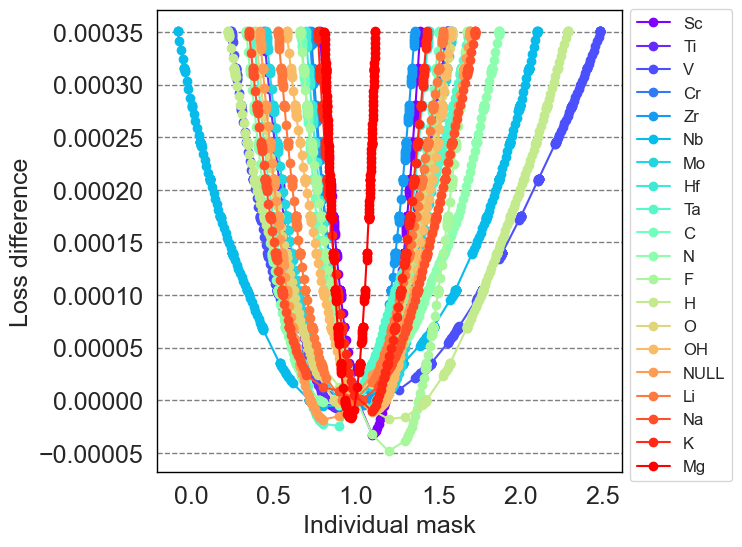

In [138]:
m_training_process_vis(fis_explainer_mlp.rset_main_effect_raw['points_all_max'], fis_explainer_mlp.rset_main_effect_raw['points_all_min'], feature_names, save=True, suffix='NN')

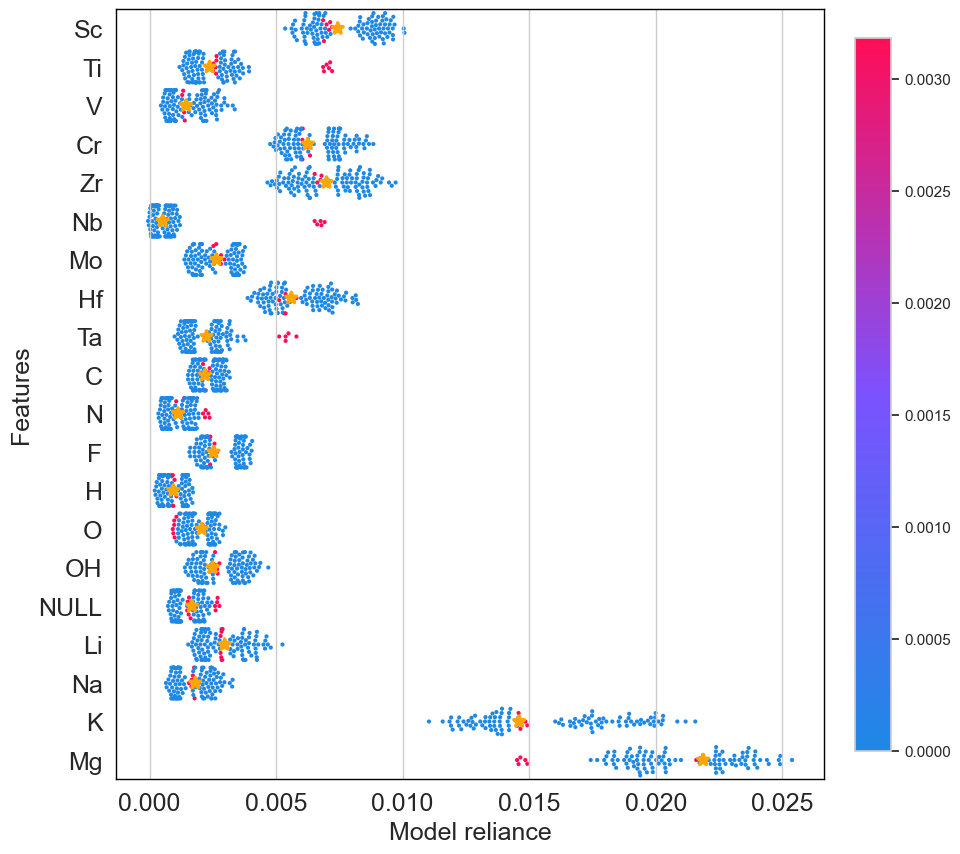

In [145]:
fis_explainer_mlp.swarm_plot_MR(interest_of_features = [0, 1 ,2 ,3] , vname = feature_names, plot_all = True, boxplot = False, save=True, suffix='NN')

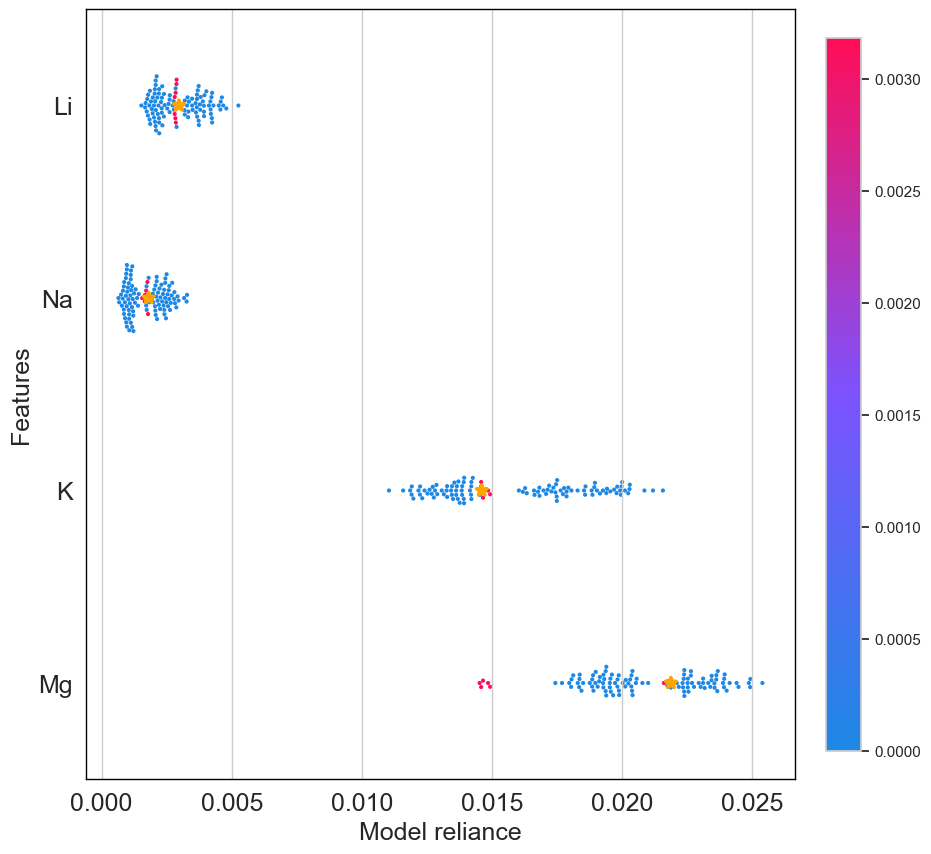

In [232]:
fis_explainer_mlp.swarm_plot_MR(interest_of_features = [16, 17, 18, 19] , vname = feature_names, plot_all = False, boxplot = False, save=True, suffix='NN-Z')

In [147]:
std = [np.std(i) for i in np.array(fis_explainer_mlp.rset_main_effect_processed['all_main_effects_diff']).transpose(
        (2, 0, 1, 3)).reshape((len(fis_explainer_mlp.v_list), -1))]
std

[0.001343876152792779,
 0.0012809576754877201,
 0.0007691432735415,
 0.001085717794081236,
 0.0013156032074650474,
 0.001337505855705058,
 0.0007521855555937653,
 0.0011591749505325338,
 0.0009794077780727716,
 0.0004573475038678762,
 0.000528332780008213,
 0.0007622267838862396,
 0.000438750494055681,
 0.0005672510612951378,
 0.0008734539692005597,
 0.0005289614274464189,
 0.0009032027104219697,
 0.0007084464499597656,
 0.002793315062434887,
 0.002432712708405127]

In [264]:
def plot_feature_importance(ft_set, feature_importance, show_cols = 30):

    fig = plt.figure(figsize=(12,4))
    w_lr_sort, ft_sorted, sorted_index_pos = return_feature_importance(ft_set, feature_importance, show_cols = show_cols)
    x_val = list(range(len(w_lr_sort)))
    ax = plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    barlist=plt.bar(x_val, w_lr_sort)
    for i in range(9):
        m = sorted_index_pos.index(i)
        barlist[m].set_color(colors_vis(c=1))
    for i in range(9,11):
        m = sorted_index_pos.index(i)
        barlist[m].set_color(colors_vis(c=2))
    for i in range(11, 16):
        # print(i)
        m = sorted_index_pos.index(i)
        barlist[m].set_color(colors_vis(c=4))
    for i in range(16, 20):
        m = sorted_index_pos.index(i)
        barlist[m].set_color(colors_vis(c=3))
    barlist[0].set_height(66)
    plt.xlabel('Feature', fontsize=16)
    plt.ylabel('Ranking', fontsize=16)
    plt.xticks(x_val, ft_sorted, rotation='vertical')

    return fig

def return_feature_importance(ft_set, feature_importance, show_cols = 30):

    w_lr = copy(np.abs(feature_importance))
    w_lr = 100 * (w_lr / w_lr.max())
    sorted_index_pos = [index for index, num in sorted(enumerate(w_lr), key=lambda x: x[-1],
                   reverse=True)]

    ft_sorted = []
    w_lr_sort = []
    for i, idx in enumerate(sorted_index_pos):
        if i > show_cols:
            break
        ft_sorted.append(ft_set[idx])
        w_lr_sort.append(w_lr[idx])

    return w_lr_sort, ft_sorted, sorted_index_pos

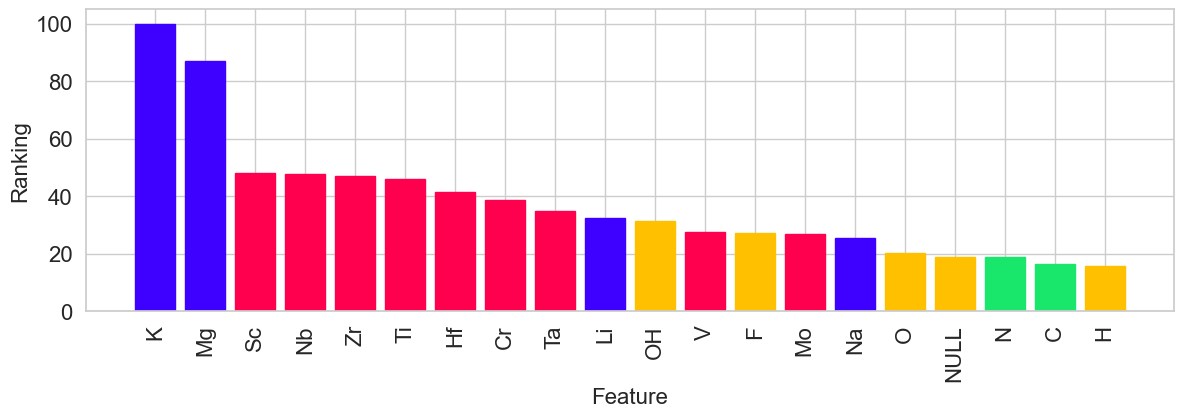

In [217]:
plot_feature_importance(
    X_features.columns,
    std,
    show_cols = 20
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# plt.savefig('../results/figs/feature_importance_nn.png', dpi = 300, bbox_inches='tight')

plt.show()

## save results in a table

In [222]:
results_csv = np.zeros((20, 4))
for idx,i in enumerate(np.array(fis_explainer_mlp.rset_main_effect_processed['all_main_effects_diff']).transpose(
        (2, 0, 1, 3)).reshape((len(fis_explainer_mlp.v_list), -1))):
    results_csv[idx, 0] = np.average(i)
    results_csv[idx, 1] = np.min(i)
    results_csv[idx, 2] = np.max(i)
    results_csv[idx, 3] = np.std(i)

In [223]:
np.savetxt("../results/figs/result.csv", results_csv, delimiter=",")

# Integrating domain knowledge and model selection

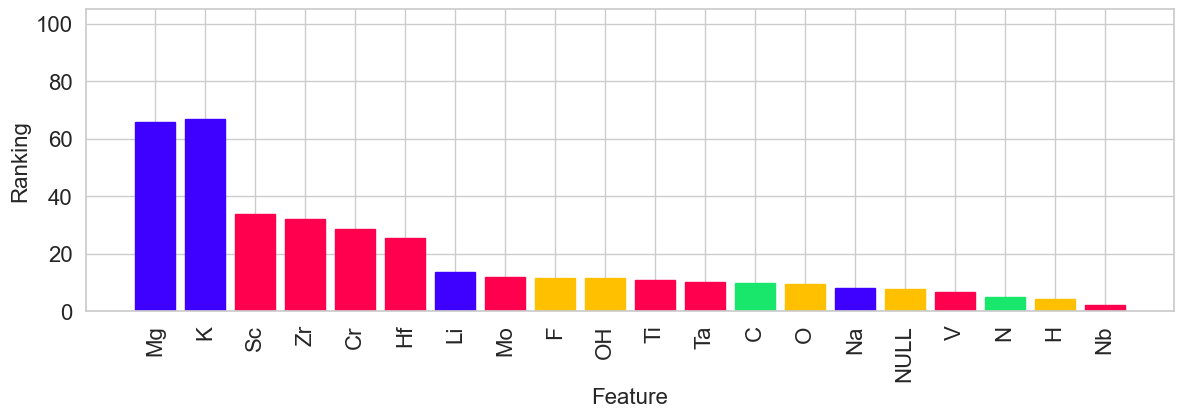

In [265]:
plot_feature_importance(
    X_features.columns,
    fis_explainer_mlp.ref_analysis['ref_main_effects'],
    show_cols = 20
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.savefig('../results/figs/feature_importance_nn_Mg.png', dpi = 300, bbox_inches='tight')
plt.show()


In [261]:
Mg_min = min(np.array(fis_explainer_mlp.rset_main_effect_processed[
            'all_main_effects_diff']).transpose(
            (2, 0, 1, 3)).reshape((len(fis_explainer_mlp.v_list), -1))[-1])
Nb_max = max(np.array(fis_explainer_mlp.rset_main_effect_processed[
            'all_main_effects_diff']).transpose(
            (2, 0, 1, 3)).reshape((len(fis_explainer_mlp.v_list), -1))[5])